#### DR Preprocessing Comparison
Need to figure out the best way to reduce the dimensionality of the scRNA-seq data prior to calculating EMDs for subpopulation comparison.

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [58]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 33.5 s, sys: 6.64 s, total: 40.1 s
Wall time: 42.2 s


In [3]:
top20 = list(range(1,21))

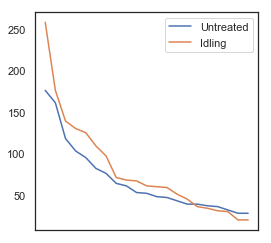

In [100]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [5]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)


Perform PCA on each dataset to prime DRs

In [19]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 13.7 s, sys: 2.96 s, total: 16.7 s
Wall time: 12.6 s


In [20]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 17.2 s, sys: 4.79 s, total: 22 s
Wall time: 17.2 s


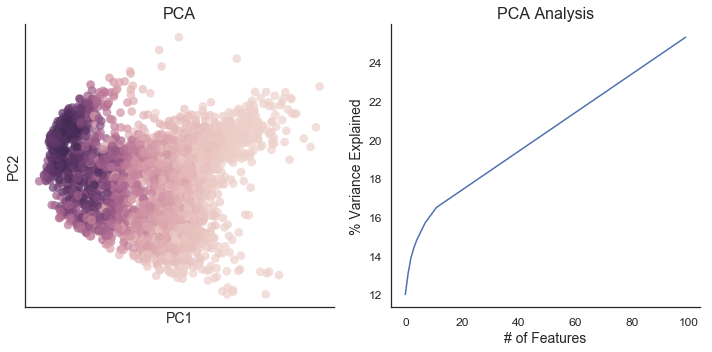

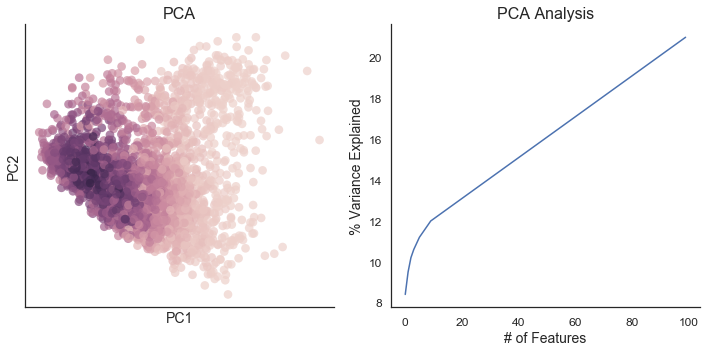

In [21]:
# visualize both PCAs
U_PCA.plot()
I_PCA.plot()

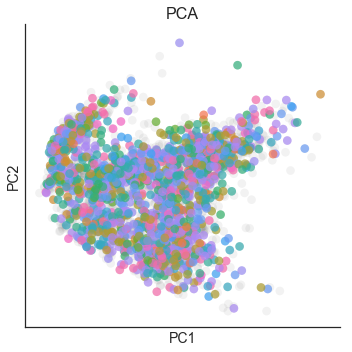

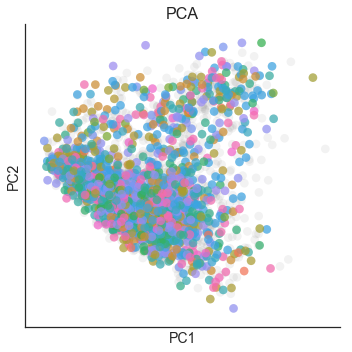

In [97]:
U_PCA.plot_barcodes(selected_codes)
I_PCA.plot_barcodes(selected_codes)

---
### t-SNE
Primed with 100-component PCA. FIt-SNE implementation.

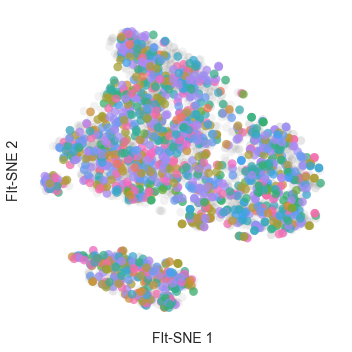

CPU times: user 964 ms, sys: 112 ms, total: 1.08 s
Wall time: 29.2 s


In [9]:
%%time 
U_FItSNE = fcc_FItSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_FItSNE.plot_barcodes(ranks=selected_codes)

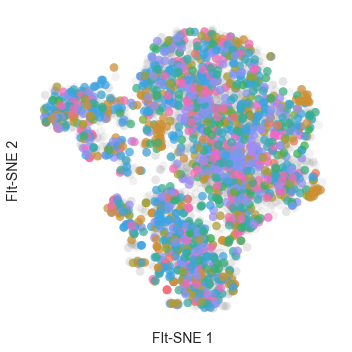

CPU times: user 1.24 s, sys: 95 ms, total: 1.33 s
Wall time: 24.1 s


In [10]:
%%time 
I_FItSNE = fcc_FItSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_FItSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

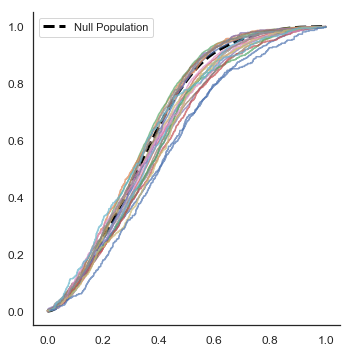

CPU times: user 31.9 s, sys: 997 ms, total: 32.9 s
Wall time: 32.7 s


In [11]:
%%time
U_out = compare_barcode_distances(obj=U_FItSNE, barcodes=selected_codes)

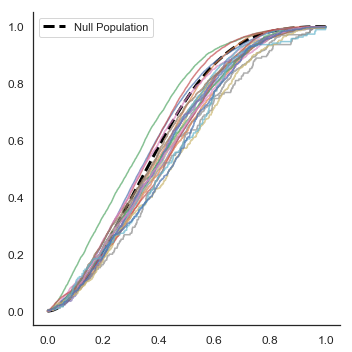

CPU times: user 49.5 s, sys: 1.8 s, total: 51.3 s
Wall time: 51.4 s


In [12]:
%%time
I_out = compare_barcode_distances(obj=I_FItSNE, barcodes=selected_codes)

In [13]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_FItSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 57s, sys: 5.35 s, total: 4min 3s
Wall time: 4min 3s


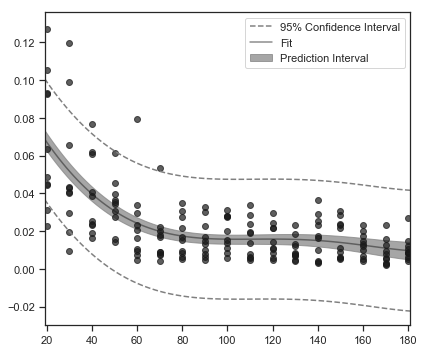

In [26]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=5)

Do the same as above for __Idling__ dataset

In [15]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_FItSNE, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 4s, sys: 12.3 s, total: 9min 17s
Wall time: 11min 18s


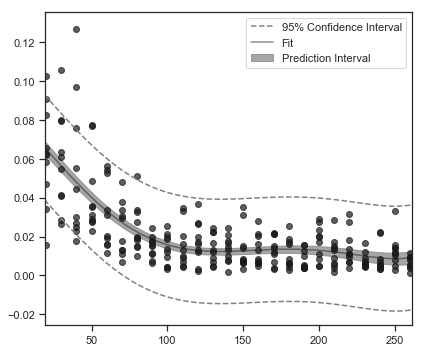

In [25]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=5)

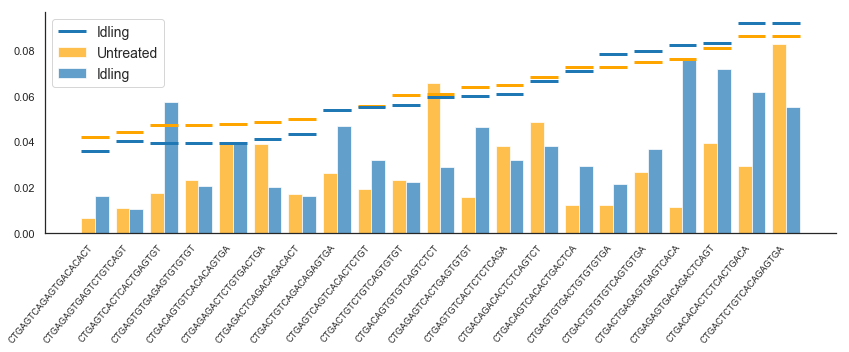

In [27]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], label='Idling',
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### UMAP
Primed with 100-component PCA. 

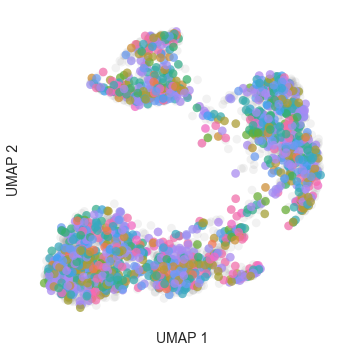

CPU times: user 12.5 s, sys: 871 ms, total: 13.4 s
Wall time: 13.5 s


In [22]:
%%time 
U_UMAP = fcc_UMAP(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_UMAP.plot_barcodes(ranks=selected_codes)

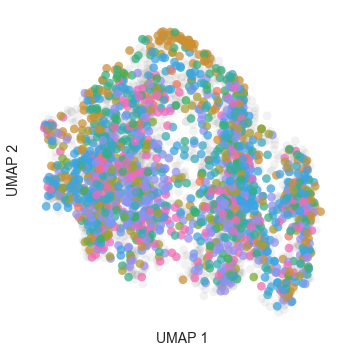

CPU times: user 10.4 s, sys: 567 ms, total: 11 s
Wall time: 10.6 s


In [23]:
%%time 
I_UMAP = fcc_UMAP(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_UMAP.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

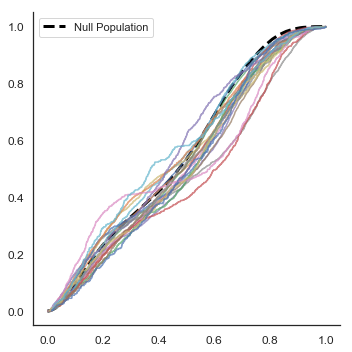

CPU times: user 32 s, sys: 1.27 s, total: 33.3 s
Wall time: 33.3 s


In [24]:
%%time
U_out = compare_barcode_distances(obj=U_UMAP, barcodes=selected_codes)


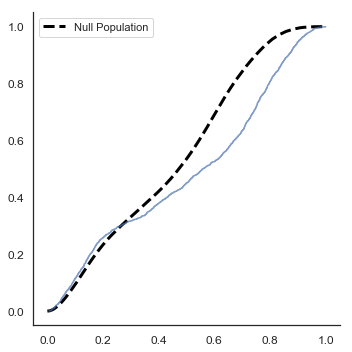

CPU times: user 2.54 s, sys: 287 ms, total: 2.83 s
Wall time: 2.71 s


,EMD,KLD,code
0,0.074993,7.664777,CTGACTGTCAGACAGAGTGA


In [95]:
%%time
compare_barcode_distances(obj=U_UMAP, barcodes=[selected_codes[7]])

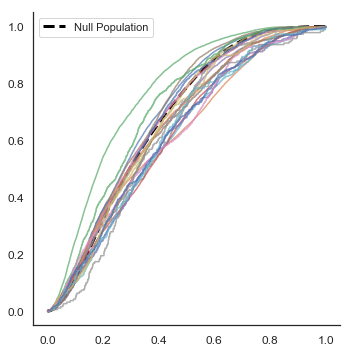

CPU times: user 49.3 s, sys: 1.9 s, total: 51.2 s
Wall time: 51.1 s


In [25]:
%%time
I_out = compare_barcode_distances(obj=I_UMAP, barcodes=selected_codes)


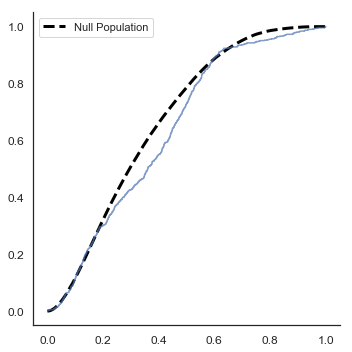

CPU times: user 3.65 s, sys: 439 ms, total: 4.08 s
Wall time: 4.01 s


,EMD,KLD,code
0,0.03382,9.197689,CTGACTGTCAGACAGAGTGA


In [96]:
%%time
compare_barcode_distances(obj=I_UMAP, barcodes=[selected_codes[7]])

In [26]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 56s, sys: 6.12 s, total: 4min 2s
Wall time: 4min 3s


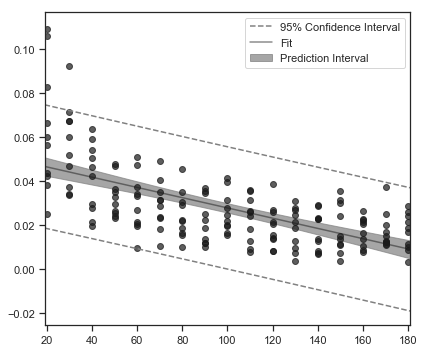

In [68]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=1)


Do the same as above for __Idling__ dataset

In [28]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 32s, sys: 8.3 s, total: 4min 41s
Wall time: 4min 41s


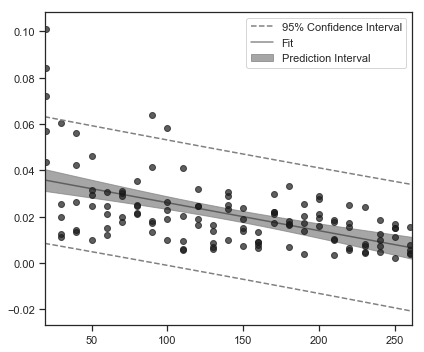

In [67]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=1)


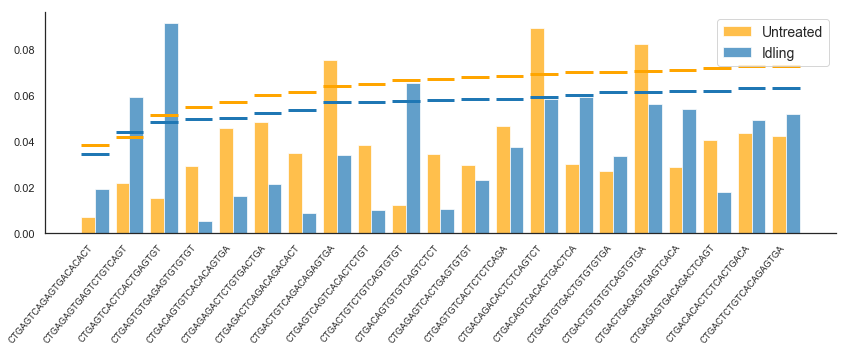

In [69]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

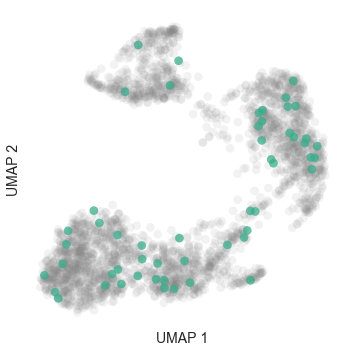

In [105]:
U_UMAP.plot_barcodes(ranks=[selected_codes[9]])

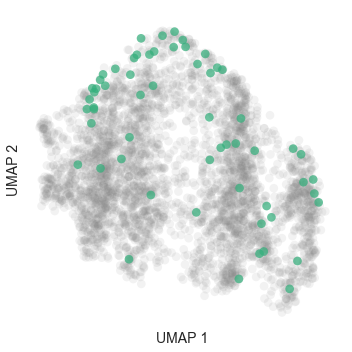

In [106]:
I_UMAP.plot_barcodes(ranks=[selected_codes[9]])

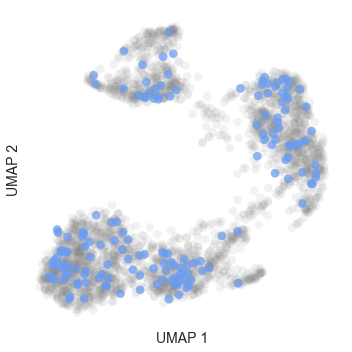

In [109]:
U_UMAP.plot_barcodes(ranks=[selected_codes[1]])


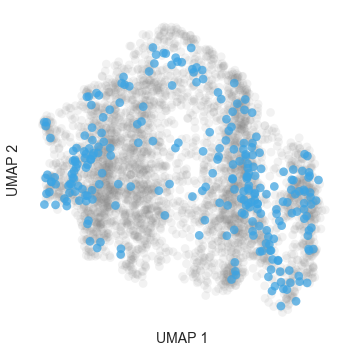

In [110]:
I_UMAP.plot_barcodes(ranks=[selected_codes[1]])


---
### DCA
Feature selection using DCA

In [6]:
%time U_DCA = fcc_DCA(matrix=U.counts, barcodes=U.barcodes, norm='arcsinh')


DCA: Successfully preprocessed 17172 genes and 2886 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 22min 41s, sys: 5min 24s, total: 28min 5s
Wall time: 13min 10s


In [7]:
%time I_DCA = fcc_DCA(matrix=I.counts, barcodes=I.barcodes, norm='arcsinh')

DCA: Successfully preprocessed 17193 genes and 3524 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 39min 11s, sys: 8min 26s, total: 47min 37s
Wall time: 28min 3s


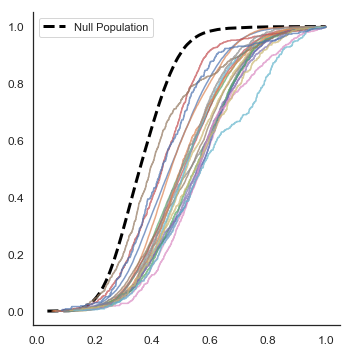

CPU times: user 7min 54s, sys: 6min 37s, total: 14min 32s
Wall time: 18min 5s


In [8]:
%%time
U_out = compare_barcode_distances(obj=U_DCA, barcodes=selected_codes)

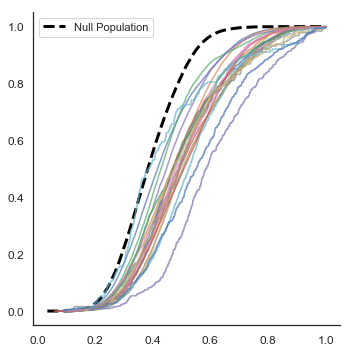

CPU times: user 11min 37s, sys: 9min 30s, total: 21min 8s
Wall time: 39min 53s


In [9]:
%%time
I_out = compare_barcode_distances(obj=I_DCA, barcodes=selected_codes)

In [10]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_DCA, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 12min 21s, sys: 7min 6s, total: 19min 28s
Wall time: 51min 8s


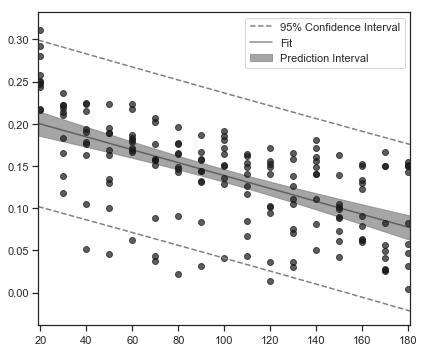

In [15]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=1)

Do the same as above for __Idling__ dataset

In [12]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_DCA, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 16min 40s, sys: 10min 3s, total: 26min 43s
Wall time: 27min 1s


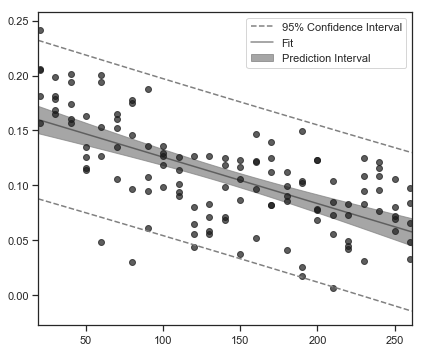

In [14]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=1)

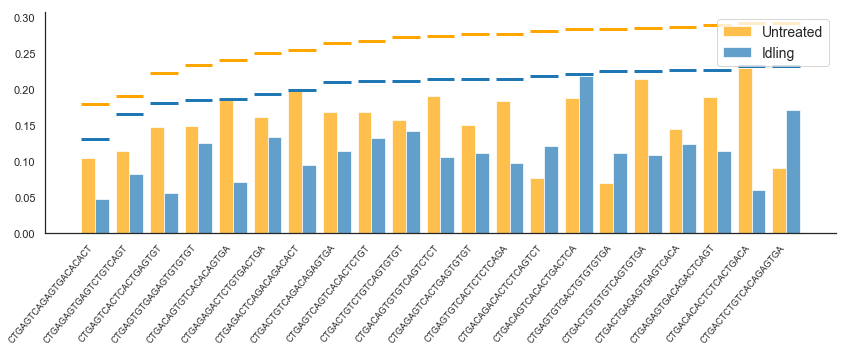

In [16]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()